# S10 T01: Aprenentage Supervisat
### Objectius
- Arbres de classificació
- KNN - k-Nearest Neighbors
- Regressió Logística
- Support Vector Machine
- XGboost

### Sources


### Imports



In [1]:
# Yolo
import warnings
warnings.filterwarnings('ignore')

# Scientific and Data Manipulation Libraries :
import numpy as np
import pandas as pd



# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

# ML Libraries
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve, auc

# Retrieve stored dataframe from previous exercise (S09_T01)
%store -r robust_df

# Retrieve train_test Data from previous exercice(S09_T01)
%store -r X_train
%store -r X_test
%store -r y_train
%store -r y_test

# Set Random seed for reproducibility
random_state = 0

### Methods(None)

###  Foreword
Since we keep using the same data from the previous exercices, in order to keep clarity and awareness of the whole data processing done before, some tables are facilitated below.

There were two big clusters of NaNs:
- one was affecting the features relative to causes of delay (Carrier, Weather, NAS, Security, LateAircraftdelay) but their Nans were due to the fact that according to the Official Bureau of Transportations, less than 15 minute of Delay is considered "on-time", hence these delay types don't apply.
- second was affecting the features AirTime and ArrDelay, further checks helped us spot that all this Nans were due to the fact that the flight had either been Cancelled or Diverted, so if there's no flight there can't be airtime or delay.


Subsequently, all Nans where replaced with zeros and data was Robust Scaled due to the outliers present in the dataset. And this is the dataset used in this exercice.

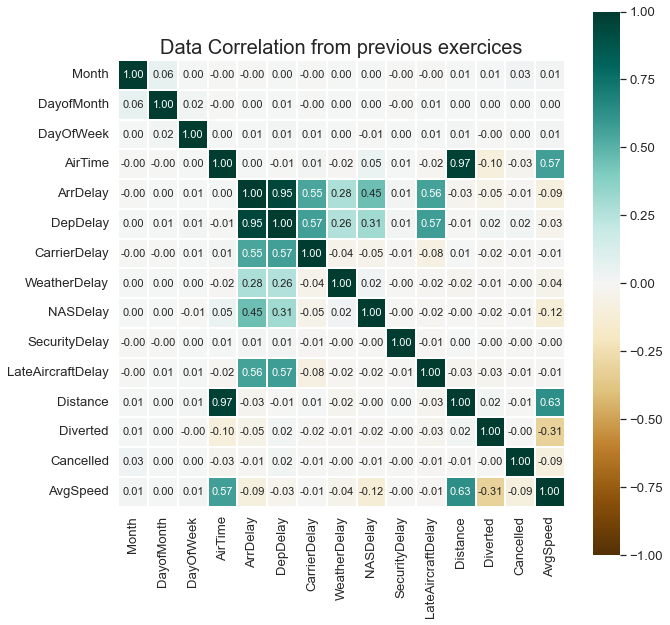

In [2]:
# Check correlation between variables
data_corr = robust_df.corr()

# set style and plot:
sb.set(font_scale=1.2) 
fig, ax = plt.subplots(figsize=(10,10))
ax = sb.heatmap(data = data_corr, 
               square = True,
               annot = True,
               cmap = 'BrBG',
               vmin = -1,
               vmax = 1,
               center = 0, 
               linewidths=2,
               ax=ax, 
               annot_kws={"size":11}, fmt='.2f')
            
plt.title('Data Correlation from previous exercices', fontsize=20)
plt.show()
plt.close()

>Based on exercice (S09_T01), **since AvgSpeed was an  
instrumental variable** created ad-hoc to discern realistic values, within 
Distance and AirTime, and it doesn't show a strong correlation 
with any of the other variables **and contains some infinite values(since some AirTimes were=0).I assume it's safe to drop it along with categorical features** for the latter didn't showed any particular insights besides the normally-distributed logic of more flights equals more delays 

In [3]:
# Dropping the columns
robust_df.drop(['AvgSpeed','Distance', 'Month', 'DayofMonth', 'DayOfWeek'], axis=1, inplace=True)
# Check resulting Dataframe
a,b = robust_df.shape
print(f'Used dataset contains {b} features and {a} samples')
display(robust_df.describe())

Used dataset contains 10 features and 1936302 samples


,AirTime,ArrDelay,DepDelay,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,Diverted,Cancelled
count,1.936302e+06,1.936302e+06,1.936302e+06,1.936302e+06,1.936302e+06,1.936302e+06,1.936302e+06,1.936302e+06,1.936302e+06,1.936302e+06
mean,2.255721e-01,3.914724e-01,4.678182e-01,1.235321e+00,2.383129e+00,1.611419e+00,5.806584e-02,9.052018e-01,4.004541e-03,3.269118e-04
std,8.716506e-01,1.232946e+00,1.302338e+00,3.613088e+00,1.733218e+01,4.678544e+00,1.624102e+00,1.992071e+00,6.315462e-02,1.807775e-02
min,-1.139241e+00,-2.043478e+00,-4.390244e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,-4.050633e-01,-3.260870e-01,-2.926829e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,5.949367e-01,6.739130e-01,7.073171e-01,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
max,1.267089e+01,5.297826e+01,5.958537e+01,2.436000e+02,1.352000e+03,2.261667e+02,3.920000e+02,7.311111e+01,1.000000e+00,1.000000e+00


>Ass seen above, we reduced initial features number down to 10. This included:
- AirTime: One of the most important features, it was higly correlated with Distance (0,98) and then the latter was taken out since the provided information was almost the same.

- ArrDelay: it's the target feature.

- DepDelay: The main feature related to target. It poses a 0,95 wich is a really high correlation 

- CarrierDelay/WeatherDelay/NASDelay/SecurityDelay/LateAircraftDelay: Amalgamation of Delay causes, altogether provide valuable insights being important independent variables, that's the main reason behind keeping them and discarding all the other compound variables like TaxiIn/taxiOut, Estimated scheduled times (CRS's)  and Delay since ArrDelay and DepDelay are their by-products.

- Diverted/Cancelled: These Binary provided useful info since allowed us to detect anomalies within Airtime (like for instance a 0 min Airtime wich showed infinite values for the purposefully created AverageSpeed).

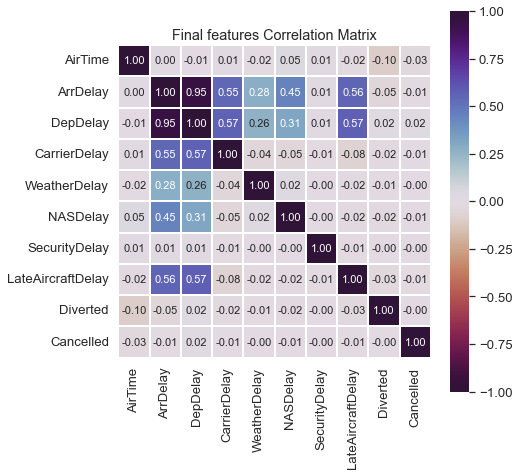

In [4]:
# Check correlation between final selected variables
data_corr = robust_df.corr()

# set style and plot:
sb.set(font_scale=1.2) 
fig, ax = plt.subplots(figsize=(7,7))
ax = sb.heatmap(data = data_corr, 
               square = True,
               annot = True,
               cmap = 'twilight_shifted_r',
               vmin = -1,
               vmax = 1,
               center = 0, 
               linewidths=2,
               ax=ax, 
               annot_kws={"size":11}, fmt='.2f')
            
ax.set(title='Final features Correlation Matrix')
plt.show()
plt.close()


# Exercici 1

Crea almenys tres models de classificació diferents per intentar predir el millor possible l’endarreriment dels vols (ArrDelay) de DelayedFlights.csv. Considera si el vol ha arribat tard o no (ArrDelay > 0).
>Given the fact that our target feature is continuous and we only need to provide a Binary answer, we'll just convert y_train and y_test based on the above stated condition (ArrDelay > 0).

>We might as well check if y-train/test are balanced.

>Therefore since our target variable is binary we'll use AUC (Area Under Curve), precision score and confusion matrix as the main evaluation metrics.

In [5]:
# Transform y_train and y_test (a.k.a. Arrival Delay) to binary
y_test['ArrDelay'] = np.where(y_test['ArrDelay'].lt(0),0,1)
y_train['ArrDelay'] = np.where(y_train['ArrDelay'].lt(0),0,1) 

# Check values in target splits to see if they are balanced
print('Y_train:')
display(y_train.value_counts())

print('Y_test:')
display(y_test.value_counts())

Y_train:


ArrDelay
1           690639
0           664772
dtype: int64

Y_test:


ArrDelay
1           296552
0           284339
dtype: int64

>Yep, they're pretty much balanced so let's go with the models

___
## Logistic regression model

In [6]:
# Create object
logregr = LogisticRegression()

# Train model
logregr.fit(X_train, y_train)

# Make predictions
y_predictions = logregr.predict(X_test)

###  Evaluation metrics

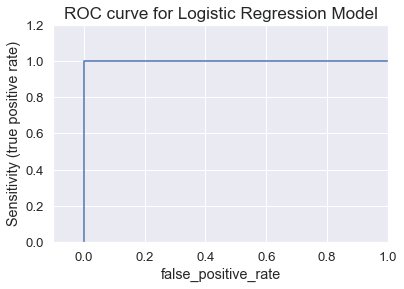

Train Score 1.0
Test Score 1.0


In [7]:
# Evaluation metrics
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_predictions)
log_auc = auc(false_positive_rate, true_positive_rate)
log_accur = metrics.accuracy_score(y_test, y_predictions)
log_prec = metrics.precision_score(y_test, y_predictions) 
log_rec = metrics.recall_score(y_test, y_predictions)
# Plot ROC curve
plt.plot(false_positive_rate, true_positive_rate)
plt.xlim([-0.1,1.0])
plt.ylim([0.0,1.2])
plt.title('ROC curve for Logistic Regression Model', fontsize=17)
plt.xlabel('false_positive_rate')
plt.ylabel('Sensitivity (true positive rate)')
plt.show()
plt.close('all')
print ('Train Score', logregr.score(X_train, y_train))
print('Test Score', logregr.score(X_test, y_test))


###  Confusion Matrix

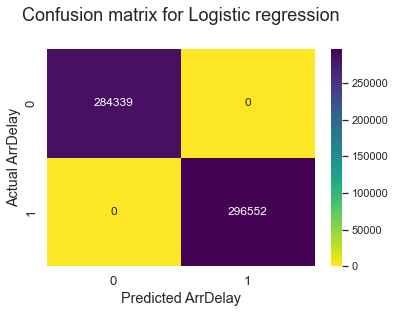

In [8]:
cnf_matrix = metrics.confusion_matrix(y_test, y_predictions)

# plotting matrix
class_names=[0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sb.set()
sb.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="viridis_r" ,fmt='g')
plt.title('Confusion matrix for Logistic regression', y=1.1, fontsize=18)
plt.ylabel('Actual ArrDelay')
plt.xlabel('Predicted ArrDelay')
plt.show()
plt.close()

___
## Random Forest Classifier Model

In [9]:
# Create Object
rfc_clasif = RandomForestClassifier()

# Train the model
rfc_clasif.fit(X_train, y_train)

# Predict Values
y_predictions = rfc_clasif.predict(X_test)

###  Evaluation metrics

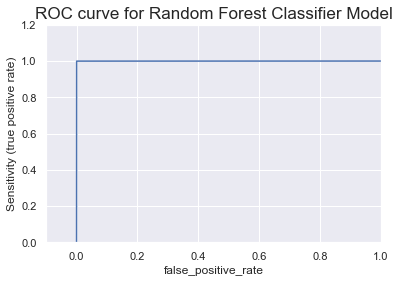

Train Score:  1.0
Test Score:  0.9996367649008162


In [10]:
# Evaluation metrics
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_predictions)
rfc_auc = auc(false_positive_rate, true_positive_rate)
rfc_accur = metrics.accuracy_score(y_test, y_predictions)
rfc_prec = metrics.precision_score(y_test, y_predictions) 
rfc_rec = metrics.recall_score(y_test, y_predictions)
# Plot ROC curve
plt.plot(false_positive_rate, true_positive_rate)
plt.xlim([-0.1,1.0])
plt.ylim([0.0,1.2])
plt.title('ROC curve for Random Forest Classifier Model', fontsize=17)
plt.xlabel('false_positive_rate')
plt.ylabel('Sensitivity (true positive rate)')
plt.show()
plt.close('all')
print ('Train Score: ', rfc_clasif.score(X_train, y_train))
print('Test Score: ',rfc_clasif.score(X_test, y_test))

###  Confusion Matrix

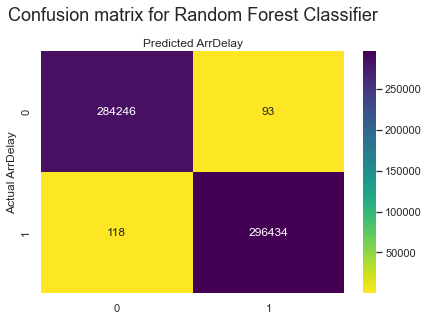

In [11]:
cnf_matrix = metrics.confusion_matrix(y_test, y_predictions)

# plotting matrix
class_names=[0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sb.set()
sb.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="viridis_r" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix for Random Forest Classifier', y=1.1, fontsize=18)
plt.ylabel('Actual ArrDelay')
plt.xlabel('Predicted ArrDelay')
plt.show()
plt.close()

___
## Multi-layer Perceptron classifier (MLPC) Model

In [12]:
# Create Object
nn_clasif = MLPClassifier()

# Train the model
nn_clasif.fit(X_train, y_train)

# Predict Values
y_predictions = nn_clasif.predict(X_test)

###  Evaluation metrics

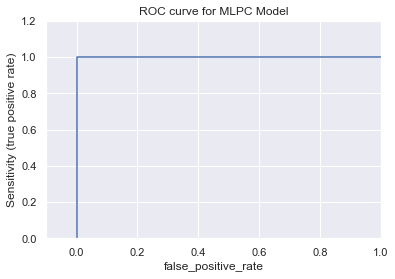

Train Score 1.0
Test Score 1.0


In [13]:
# Evaluation metrics
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_predictions)
mlpc_auc = auc(false_positive_rate, true_positive_rate)
mlpc_accur = metrics.accuracy_score(y_test, y_predictions)
mlpc_prec = metrics.precision_score(y_test, y_predictions) 
mlpc_rec = metrics.recall_score(y_test, y_predictions)
# Plot ROC curve
plt.plot(false_positive_rate, true_positive_rate)
plt.xlim([-0.1,1.0])
plt.ylim([0.0,1.2])
plt.title('ROC curve for MLPC Model')
plt.xlabel('false_positive_rate')
plt.ylabel('Sensitivity (true positive rate)')
plt.show()
plt.close('all')

print ('Train Score', nn_clasif.score(X_train, y_train))
print('Test Score', nn_clasif.score(X_test, y_test))

###  Confusion Matrix

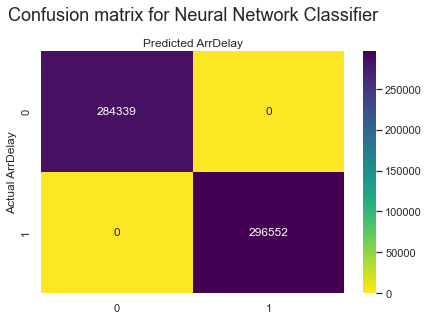

In [14]:
cnf_matrix = metrics.confusion_matrix(y_test, y_predictions)

# plotting matrix
class_names=[0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sb.set()
sb.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="viridis_r" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix for Neural Network Classifier', y=1.1, fontsize=18)
plt.ylabel('Actual ArrDelay')
plt.xlabel('Predicted ArrDelay')
plt.show()
plt.close()

___
## Exercici 2

Compara els models de classificació utilitzant la precisió (accuracy), una matriu de confiança i d’altres mètriques més avançades.
>Evaluation metrics comparison below, for confusion matrixes and ROC curve check every model above.

In [15]:
# Print results for evaluation
print('Model comparison on Area Under the Curve (AUC-ROC)\n')

print(f'AUC-ROC for Logistic Regression Model: {log_auc:.6f}')
print(f'AUC-ROC for Random Forest Model: {rfc_auc:.6f}')
print(f'AUC-ROC for Neural Network Model: {mlpc_auc:.6f}\n')

print('Model comparison on Accuracy \n')

print(f'Accuracy for Logistic Regression Model: {log_accur:.6f}')
print(f'Accuracy for Random Forest Model: {rfc_accur:.6f}')
print(f'Accuracy for Neural Network Model: {mlpc_accur:.6f}\n')

print('\nModel comparison on Precision:\n')

print(f"Precision for Logistic Regression Model: {log_prec:.6f}")
print(f"Precision for Random Forest Model: {rfc_prec:.6f}")
print(f"Precision for Neural Network Model: {mlpc_prec:.6f}")

print('\nModel comparison on Recall:\n')

print(f"Recall for Logistic Regression Model: {log_rec:.6f}")
print(f"Recall for Random Forest Model: {rfc_rec:.6f}")
print(f"Recall for Neural Network Model: {mlpc_rec:.6f}")


Model comparison on Area Under the Curve (AUC-ROC)

AUC-ROC for Logistic Regression Model: 1.000000
AUC-ROC for Random Forest Model: 0.999638
AUC-ROC for Neural Network Model: 1.000000

Model comparison on Accuracy 

Accuracy for Logistic Regression Model: 1.000000
Accuracy for Random Forest Model: 0.999637
Accuracy for Neural Network Model: 1.000000


Model comparison on Precision:

Precision for Logistic Regression Model: 1.000000
Precision for Random Forest Model: 0.999686
Precision for Neural Network Model: 1.000000

Model comparison on Recall:

Recall for Logistic Regression Model: 1.000000
Recall for Random Forest Model: 0.999602
Recall for Neural Network Model: 1.000000


>As we can see, there seems to be some overfitting spreaded across our models. The fact that the random forest models are least likely to overfit could explain that , since RFC metrics where expected to surpass the logistic model
___
## Exercici 3

Entrena’ls utilitzant els diferents paràmetres que admeten.

>Here we'll use RandomizedSearchCV on the random Forest Classifier() , returning the set of parameters that lay the best score internally using cross validation, but since values are to be considered overfitted, we'll try to reduce performance with a tree depth reduction, meaning the less tree depth the less complexity. 

In [19]:
# Previous RFC Model Scores
print ('Train Score: ', rfc_clasif.score(X_train, y_train))
print('Test Score: ',rfc_clasif.score(X_test, y_test))
# Number of trees in random forest
n_estimators = [1,10,100]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [2,4,6,8,10]
# Minimum number of samples required to split a node
min_samples_split = [2,4,6,8,10,15]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Criterion
criterion=['gini', 'entropy']
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'criterion': criterion}

rf_base =  RandomForestClassifier()                                           
rf_random = RandomizedSearchCV(estimator=rf_base,
                               param_distributions=random_grid,
                               )
rf_random.fit(X_train, y_train)

print('Best Parameters ')
rf_random.best_params_

Train Score:  1.0
Test Score:  0.9996367649008162
Best Parameters 


{'n_estimators': 100,
 'min_samples_split': 6,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 10,
 'criterion': 'entropy',
 'bootstrap': True}

In [20]:
rfc2 = RandomForestClassifier(n_estimators = 100,
                             min_samples_split= 6,
                             min_samples_leaf= 1,
                             max_features= 'sqrt',
                             max_depth= 8, # Reducing depth reduces performance
                             criterion= 'entropy',
                             bootstrap= True)
rfc2.fit(X_train, y_train)
print('Scores after hyperparameter tunning\n')
print ('Train Score', rfc2.score(X_train, y_train))
print('Test Score', rfc2.score(X_test, y_test))

Scores after hyperparameter tunning

Train Score 0.9802089550697168
Test Score 0.9801477385602463


>We can see that model slightly improved (worsened in this case) with the hyperparameter tunning

___
## Exercici 4

Compara el seu rendiment utilitzant l’aproximació traint/test o cross-validation.

In [23]:
X = robust_df.loc[:, robust_df.columns != 'ArrDelay']
y = pd.concat([y_train,y_test])

# Cross Validations & Use average accuracy as an estimate of out-of-sample accuracy
score_a = cross_val_score(logregr, X_train, y_train, cv=5,n_jobs=-1, scoring='accuracy')
print('Logistic Regression: ', score_a)
score_b = cross_val_score(rfc2, X_train, y_train, cv=5,n_jobs=-1, scoring='accuracy')
print('RF Classifier: ', score_b)
score_c = cross_val_score(nn_clasif, X_train, y_train, cv=5,n_jobs=-1, scoring='accuracy')
print('NN Classifier: ', score_c)

Logistic Regression:  [1. 1. 1. 1. 1.]
RF Classifier:  [0.97836087 0.97974045 0.97912071 0.98039708 0.97971831]
NN Classifier:  [1. 1. 1. 1. 1.]


## Exercici 5

Realitza algun procés d’enginyeria de variables per millorar-ne la predicció

Given the fact that our aim is to Lessen accuracy instead af boosting it up.
At this point of the study we already did:
- Imputation : Substituting missing values for zeros
- One-hot enconding: Getting a dummy dataframe from Unique Carriers 
- Combine variables: AverageSpeed was a by-product column from Distance and AirTime


## Conclusions
>With this given results I'd rather choose RFC since it's less susceptible of overfitting whereas other models gave better results but they seem dubiously fitted to me.  

>Honestly...I would have preferred to get poorer results since perfection doesn't exist, and (given my neophyte condition) I am completely aware that this could spark a psychological debate about this "innate" fear about perfection amongst newbies that paradoxically makes me review my entire process steps when result is 1.0 but then I, somehow feel some type of relief when I get 0.978 . That's for another chapter for sure. 

>If this is my model, **I'd rather stick with it until I'm  plausibly taught it's wrong than tweeking knobs to get plus 0,0001** in any evaluation metric. In other words, if I believe that the results are too good to be true (besides checking) I have no need whatsoever in improving results as long as they stand to be correct according to the evaluation metrics.